## Units and variables
We will be working in natural units

$$G = c = \hbar = k_B = 1$$


Furthermore we'll be measuring distances in units of the Schwarzschild-radius, which is given by 

$$R_S = \frac{2 M G}{c^2} \qquad \text{or} \qquad R_S = 2 M \quad \text{in natural units}.$$

This radius, which was first derived by the german astronomer Karl Schwarzschild in 1916, represents the distance from a mass $m$ behind which no information can escape the gravity of the mass. Therefore it'll be irrelevant to look at distances smaller than this.

To measure distances in units of the Schwarzschild-radius, we need to dine some dimensionless variables

$$\rho = \frac{r}{R_S}, \qquad T = \frac{\tau}{R_S} \quad \text{og} \quad \lambda = \frac{l}{R_S}$$

where $\tau$ is the proper time, which in this case has units of mass. These variables represent position, time and angular momentum repsectively.

## Equations of motion and orbitals
In Newtonian mechanics, the gravitational force $\vec F_g$ due to a mass $M$ on a mass $m$ is described by

$$ \vec F_g = m \vec a = - \frac{G M m}{r^3}\, \vec r.$$

With our dimensionless variables we can now write 

$$\vec \alpha = \ddot {\vec \rho} = - \frac{\vec \rho}{2 \rho^3}.$$

Giving us four coupled differential equations.

$$\mathrm{(i)} \quad \dot \rho_x = v_x, \qquad \mathrm{(ii)} \quad \dot \rho_y = v_y, \qquad \mathrm{(iii)} \quad \ddot \rho_x = \dot v_x = - \frac{\rho_x}{2 \rho^3}, \qquad \mathrm{(iv)} \quad \ddot \rho_y = \dot v_y = - \frac{\rho_y}{2 \rho^3}.$$

With these we can find the motion of $m$ given the starting conditions $(\vec \rho_0, \vec v_0)$.

Let's define a function that takes the state of the system $s = (\vec \rho(T), \vec v(T))$ and returns $(\dot {\vec \rho}(T) , \dot {\vec v}(T))$

In [2]:
from numpy import sqrt, abs

# Funktion som finder længden af rho givet x,y
def rhoFind(x,y):
    rho = sqrt(x**2 + y**2)
    return rho

# Funktion som finder lambda givet x,y,vx,vy
def lamFind(x,y,vx,vy):
    lam = abs(vx*y - vy*x)
    return lam

# Funktion som tager startbetingelserne (s = [rhox, rhoy, vx, vy]) og beregner de tidsafledte bevægelsesligninger (rhomax, og RS er inkluderet pga 'events' i solve_ivp funktionen)
def CLdiffs(t, s, rhomax, RS):
    x,y,vx,vy=s
    rho = rhoFind(x,y)
    K = 1
    
    dx = vx
    dy = vy
    dvx = -x/(2*rho**3)*K
    dvy = -y/(2*rho**3)*K
    return [dx, dy, dvx, dvy]

# Funktion som tager startbetingelserne (s = [rhox, rhoy, vx, vy]) og beregner de tidsafledte bevægelsesligninger (rhomax, og RS er inkluderet pga 'events' i solve_ivp funktionen)
def GRdiffs(t, s, rhomax, RS):
    x,y,vx,vy=s
    rho = rhoFind(x,y)
    lam = lamFind(x,y,vx,vy)
    K = 1 + (3*lam**2)/rho**2
    
    dx = vx
    dy = vy
    dvx = -x/(2*rho**3)*K
    dvy = -y/(2*rho**3)*K
    return [dx, dy, dvx, dvy]

Now we define a function that takes that state of the system $s$ and returns the distance of $m$ to $R_S$ og $2 \left\lVert \vec \rho_0 \right\rVert$ respectively.

In [3]:
# En funktion der returnerer forskellen mellem rho og RS givet en tid og en systemtilstand.
def dyk(t, s, rhomax, RS = 1):
    x, y, vx, vy=s
    rho = rhoFind(x,y)
    return rho - RS
dyk.terminal = True

# En funktion der returnerer forskellen på rhomax og rho givet en tid og en systemtilstand.
def sprædning(t, s, rhomax, RS = 1):
    x,y,vx,vy=s
    rho = rhoFind(x,y)
    return rhomax - rho
sprædning.terminal = True

Now we define a function that solves the set of coupled differential equations. (More info in this markdown cell)

<!-- Nu skriver vi en funktion som sammenfatter de sidste par funktioner, til en numerisk løsning af vores begyndelsesværdiproblem ved brug af *scipy.integrate.solve_ivp*-funktionen. Funktionen tager som udgangspunkt systemets begyndelsestilstand $s = [\overrightarrow{\rho_0}, \overrightarrow{v_0}]$. Evt. kan den også tage en største integrationsstid (grænsen for de bundne orbitaler) som er sat til 2000 som standard, en $R_S$-værdi som er sat til 1 og en faktor med hvilken man kan skalere grænsen for sprædningsorbitalerne, som standard er den sat til 2. Funktionen returnerer så alle tiderne $ T = \left\{T_i \right\}$, positionerne $R = \left\{\overrightarrow{\rho}(T_i) | T_i \in T \right\}$, hastighederne $Y = \left\{\overrightarrow{v}(T)| T_i \in T \right\}$ og afstandende $D = \left\{||\overrightarrow{\rho}(T_i)|| \,| \,T_i \in T \right\}$. Yderligere returnerer funktionen også til hvilken tid en af grænserne (radiel dyk eller sprædningsorbital) blev nået. Hvis ikke nogen grænse blev nået returnerer den bare $T_{max}$. -->

In [4]:
from scipy.integrate import solve_ivp
from numpy import linspace

# Funtkion som returnerer tider, positioner, hastigheder, afstande og integrationstid for orbitaler, givet startværdier og evt en øvre tidsgrænse
def orbitals(s, Tmax = 2000, RS = 1, d=2, GR = False, resolution = 20000):
    y0 = x,y,vx,vy = s
    rhomax = d*rhoFind(s[0],s[1])
    t_span = [0,Tmax]
    t_eval = linspace(t_span[0], t_span[1], resolution)
    
    if GR == False:
        sol = solve_ivp(CLdiffs, t_span = t_span, y0 = y0, t_eval = t_eval, events = [sprædning, dyk], method = 'DOP853', args=(rhomax, RS))
    else:
        sol = solve_ivp(GRdiffs, t_span = t_span, y0 = y0, t_eval = t_eval, events = [sprædning, dyk], method = 'DOP853', args=(rhomax, RS))
    tim = sol.t
    pos = [sol.y[0], sol.y[1]]
    vel = [sol.y[2], sol.y[3]]
    t_events = sol.t_events
    
    rho = rhoFind(pos[0],pos[1])
    
    if len(t_events[0]) > 0:
        Tmax = t_events[0][0]
    elif len(t_events[1]) > 0:
        Tmax = t_events[1][0]
    else:
        Tmax = Tmax
    return tim, pos, vel, rho, Tmax, sol

And a function that can plot the orbitals

In [5]:
import matplotlib.pyplot as plt

# Funktion der plotter en orbital med start- og slutposition og RS givet en liste med positioner
def orbPlotter(pos, filename, RS = 1, GR = False):
    start_pos = [pos[0][0], pos[1][0]]
    end_pos = [pos[0][-1], pos[1][-1]]

    if GR == True:
        body = plt.Circle(xy=(0, 0), radius=RS, color='k')
            
        fig, ax = plt.subplots(figsize=(11,11))
        
        ax.plot(pos[0],pos[1], 'k', label = 'Orbital', linewidth=0.75)
        ax.plot(start_pos[0], start_pos[1], 'kx', label = f'Start pos: ({"%.1f" % start_pos[0]}, {"%.1f" % start_pos[1]})')
        ax.plot(end_pos[0],end_pos[1], 'k+', label = f'End pos: ({"%.1f" % end_pos[0]}, {"%.1f" % end_pos[1]})')
        ax.set_xlabel('$R_S$', fontsize = 15)
        ax.set_ylabel('$R_S$', fontsize = 15)
        # ax.set_facecolor('k')
        ax.grid(c='grey', alpha=0.2, ls ='--')
        ax.set_aspect('equal')
        ax.add_artist(body)
        ax.set_title(f'{filename}', fontsize = 20)
        ax.legend(facecolor='grey',loc='upper right', fontsize = 12)

    else:
        body = plt.Circle(xy=(0, 0), radius=RS, color='w')
        
        fig, ax = plt.subplots(figsize=(11,11))
        
        ax.plot(pos[0],pos[1], 'w', label = 'Orbital',linewidth=0.75)
        ax.plot(start_pos[0], start_pos[1], 'wx', label = f'Start pos: ({"%.1f" % start_pos[0]}, {"%.1f" % start_pos[1]})')
        ax.plot(end_pos[0],end_pos[1], 'w+', label = f'End pos: ({"%.1f" % end_pos[0]}, {"%.1f" % end_pos[1]})')
        ax.set_xlabel('$R_S$', fontsize = 15)
        ax.set_ylabel('$R_S$', fontsize = 15)
        ax.set_facecolor('k')
        ax.grid(c='grey', alpha=0.2, ls ='--')
        ax.set_aspect('equal')
        ax.add_artist(body)
        ax.set_title(f'{filename}', fontsize = 20)
        ax.legend(facecolor='grey',loc='upper right', fontsize = 12)
    
    fig.savefig(f'{filename}.png', dpi=300)

# (A) Dipping case

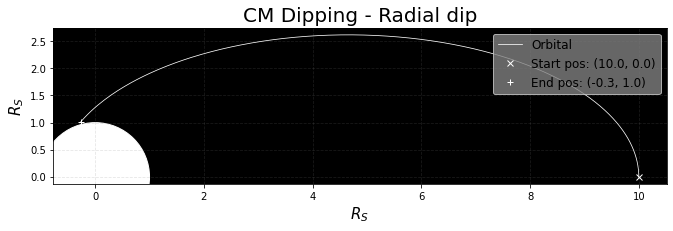

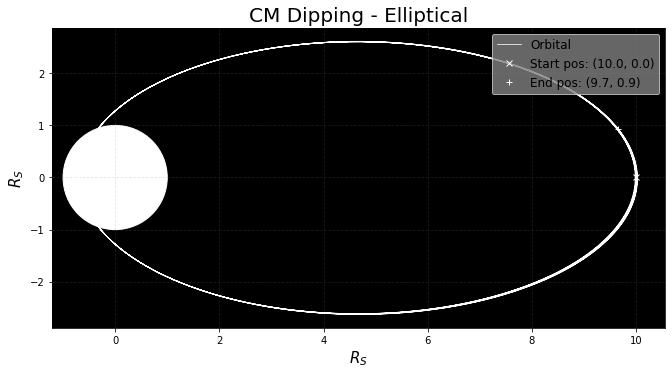

In [6]:
#CM dipping
s1 = [10,0,0,0.08]
pos1 = orbitals(s1, GR = False)[1]
orbPlot1 = orbPlotter(pos1,'CM Dipping - Radial dip')

#CM dipping (with no stopping at RS) to check whether it's elliptical
s1 = [10,0,0,0.08]
pos1 = orbitals(s1, Tmax=1000 ,RS = 0.0001, GR = False)[1]
orbPlot1 = orbPlotter(pos1,'CM Dipping - Elliptical')

# #GR 
# s1 = [10,0,0,0.08]
# pos1 = orbitals(s1, GR = True)[1]
# orbPlot1 = orbPlotter(pos1,'GR Dipping - Radial dip', GR = True)


# (B) Bound case

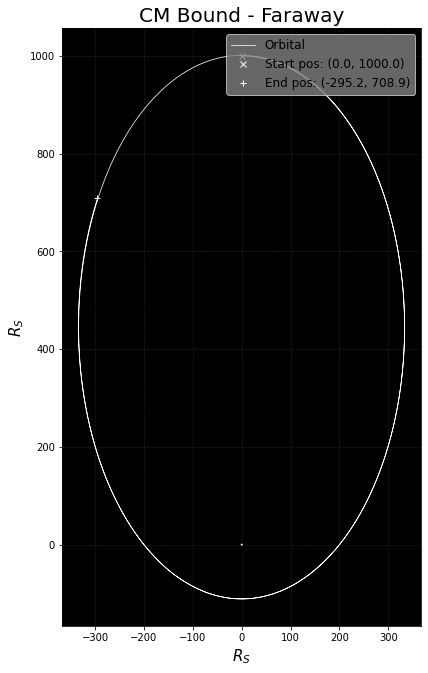

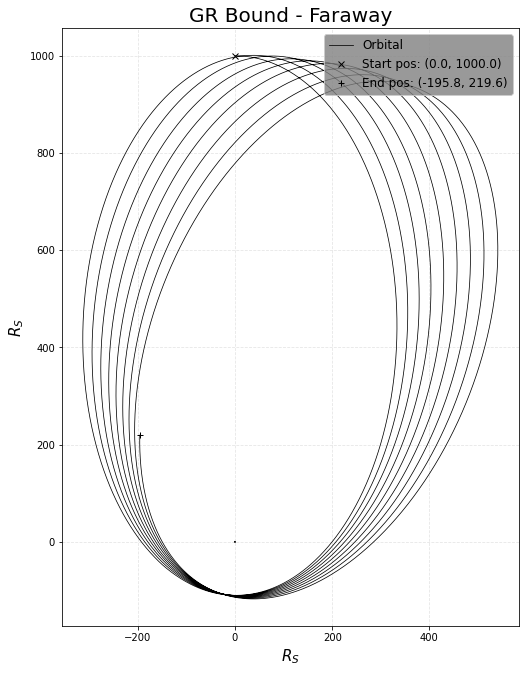

In [7]:

# #CM Bound orbital, close starting pos
# s2 = [0,10,0.2,0]
# pos2 = orbitals(s2, GR = False,Tmax = 2000)[1]
# orbPlot2 = orbPlotter(pos2,'CM Bound - Close')

#CM Bound orbital, faraway starting pos
s2 = [0,1000,0.01,0]
pos2 = orbitals(s2, GR = False,Tmax = 200000)[1]
orbPlot2 = orbPlotter(pos2,'CM Bound - Faraway')

# # GR bound orbital, close starting pos
# s2 = [0,10,0.2,0]
# pos2 = orbitals(s2, GR = True,Tmax = 2000)[1]
# orbPlot2 = orbPlotter(pos2,'GR Bound - Close', GR = True)

# GR bound orbital, faraway starting pos
s2 = [0,1000,0.01,0]
pos2 = orbitals(s2, GR = True,Tmax = 1000000)[1]
orbPlot2 = orbPlotter(pos2,'GR Bound - Faraway', GR = True)

# (C) Scattering case

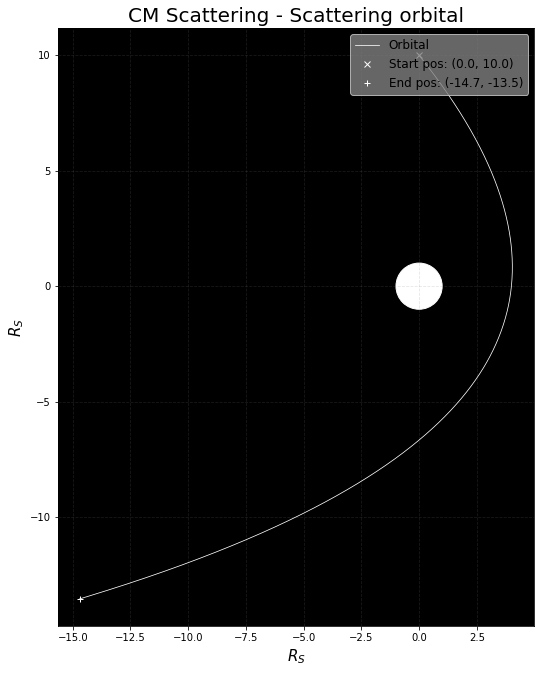

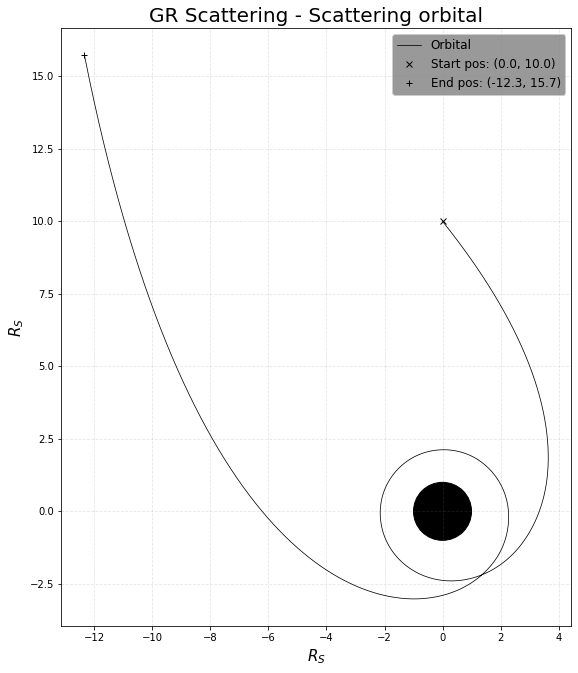

In [8]:
s3 = [0,10,0.2,-0.25]
pos3 = orbitals(s3, GR = False)[1]
orbPlot3 = orbPlotter(pos3,'CM Scattering - Scattering orbital')

s3 = [0,10,0.2,-0.25]
pos3 = orbitals(s3, GR = True)[1]
orbPlot3 = orbPlotter(pos3,'GR Scattering - Scattering orbital', GR = True)

# Starting from impact parameter and momentum

When given an impact parameter $b$, because of rotational symmetry, we can easily find the starting position "at infinity" by letting $\rho_{ix}$ be large and then setting $\rho_{iy} = b$. Of course here we're gonna use the dimensionless impact parameter

$$\beta = \frac{b}{R_s}.$$

Now when given an initial momentum $p_i$ we can turn it into a dimensionless inital velocity

$$\pi_i = $$

$$\frac{R_S \, c^3}{G} = R_s \cdot 4.037 \times 10^{35} \, \mathrm{\frac{kg}{s}} \qquad \text{or} \qquad \frac{R_S \, c^3}{G} = R_s \quad \text{in natural units}.$$

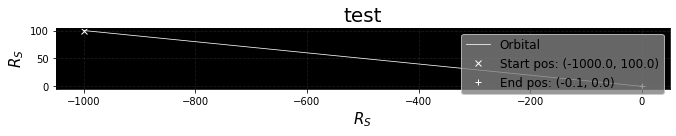

In [74]:
α = -1000
β = 100
k=1

r = sqrt(α**2 + β**2)
E = -k/(1*r)

P = findP(E, α, β)

tmax = 100000

s = [α, β, P, 0]
pos = orbitals(s, GR = True, Tmax = tmax, resolution = 10*tmax, RS = 0.0000001, d=2)[1]
orbPlot = orbPlotter(pos,'test', GR = False)
